In [1]:
setwd("~//praxiskurs_fss21/")
options(repr.plot.width=8, repr.plot.height=3,repr.plot.res = 300)
library(ggplot2)
library(magrittr)
library(tidyr)


Attaching package: 'tidyr'


The following object is masked from 'package:magrittr':

    extract




In [2]:
download.file("https://covid.ourworldindata.org/data/owid-covid-data.csv", "data/owid-covid-data.csv")

In [3]:
df_covid <- read.csv("data/RKI_COVID19.csv")
df_owid <- read.csv("data/owid-covid-data.csv")

In [4]:
df_owid$date <- as.Date(df_owid$date)
df_covid$Meldedatum <- as.Date(df_covid$Meldedatum)
dates <- seq(min(df_covid$Meldedatum)-3, max(df_covid$Meldedatum), by="day") 
df_complete  <- data.frame(dates = dates )
df_complete$cases_per_day <- sapply(dates, function(date) sum(df_covid$AnzahlFall[df_covid$Meldedatum == date])  )
df_complete$runmean_cases <- caTools::runmean(df_complete$cases_per_day, k=7, align="center")
df_complete$deaths_per_day <- sapply(dates, function(date) sum(df_covid$AnzahlTodesfall[df_covid$Meldedatum == date])  )
df_complete$runmean_deaths <- caTools::runmean(df_complete$deaths_per_day, k=7, align="center")
df_complete <- df_complete[dates<=max(df_covid$Meldedatum),]

# Impfdaten

Warning message:
"Removed 2 row(s) containing missing values (geom_path)."


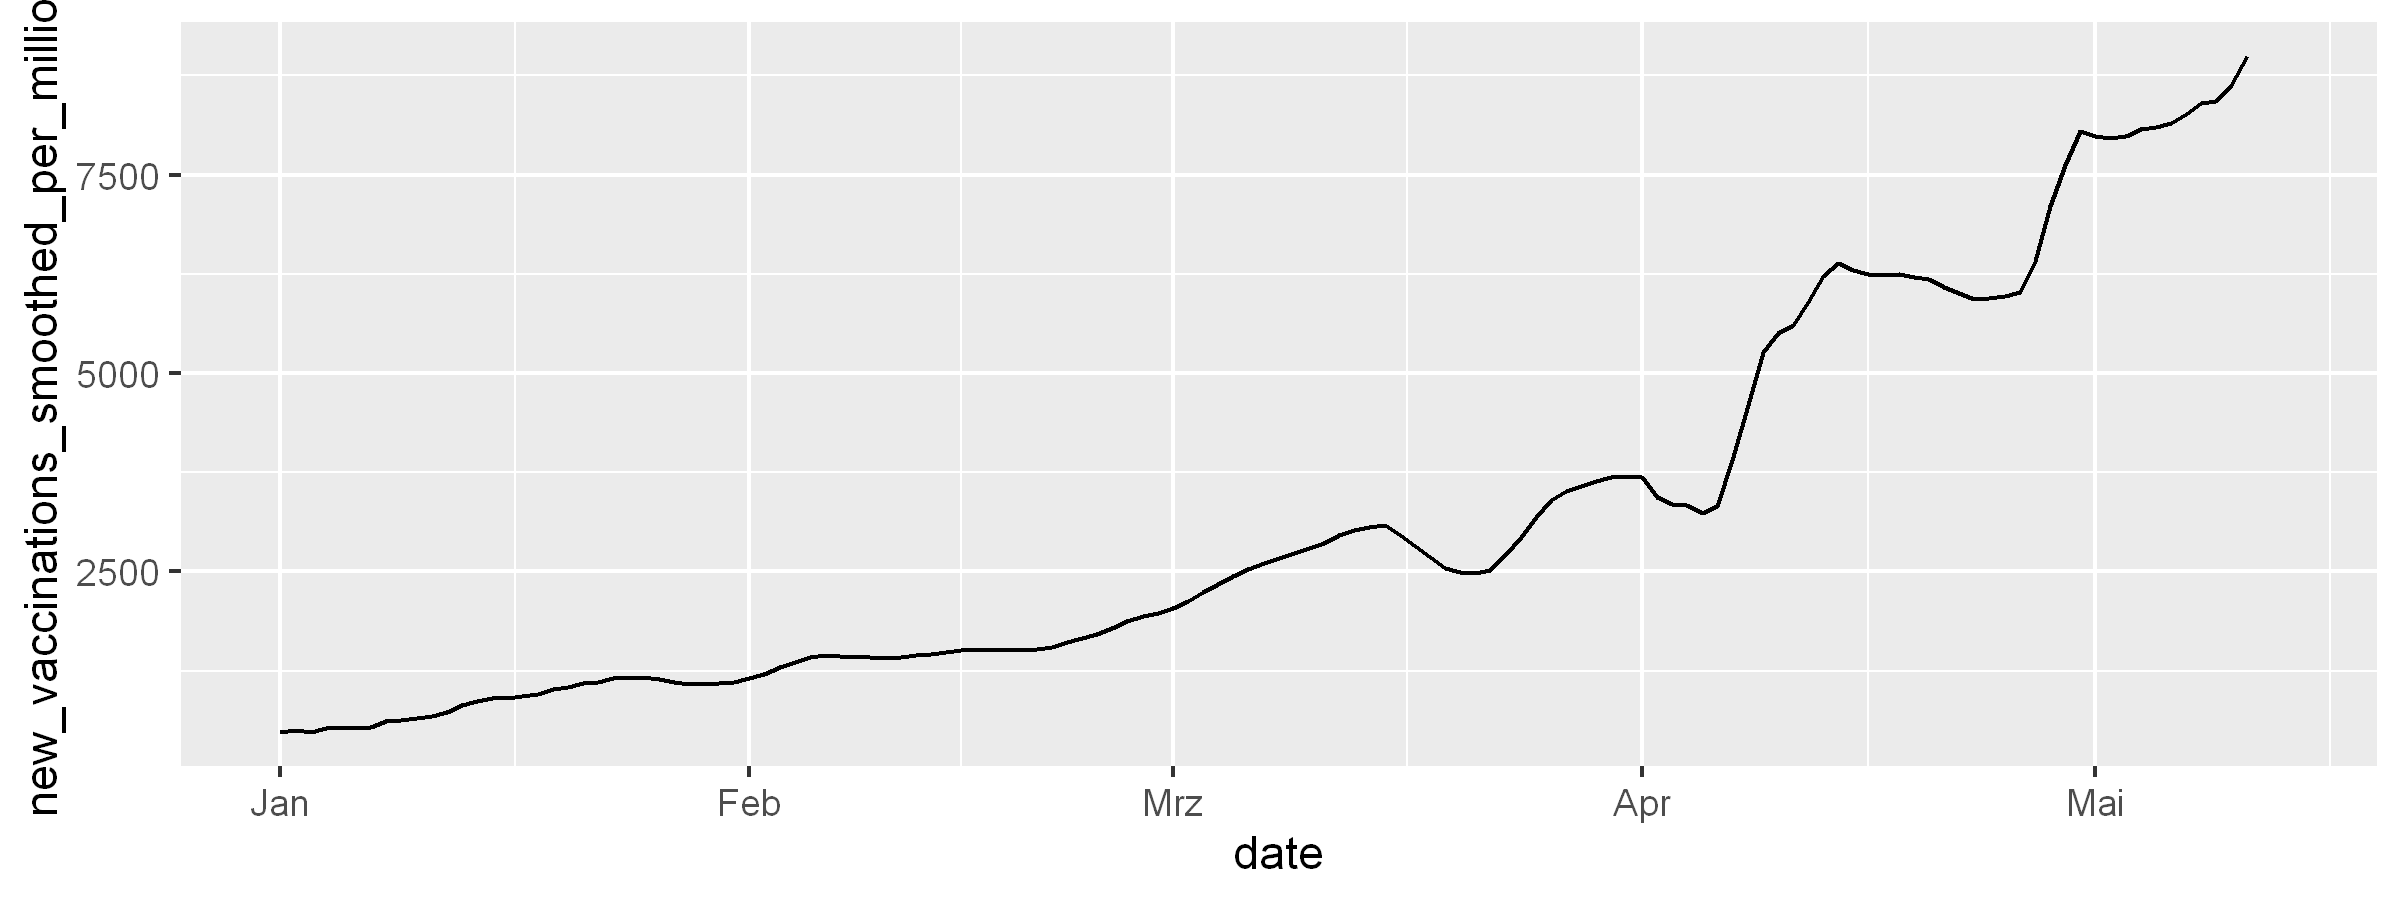

In [9]:
ggplot(df_owid[df_owid$location=="Germany" & df_owid$date>="2021-01-01",]) +
    geom_path(aes(x=date,y=new_vaccinations_smoothed_per_million)) 

Warning message:
"Removed 1998 row(s) containing missing values (geom_path)."


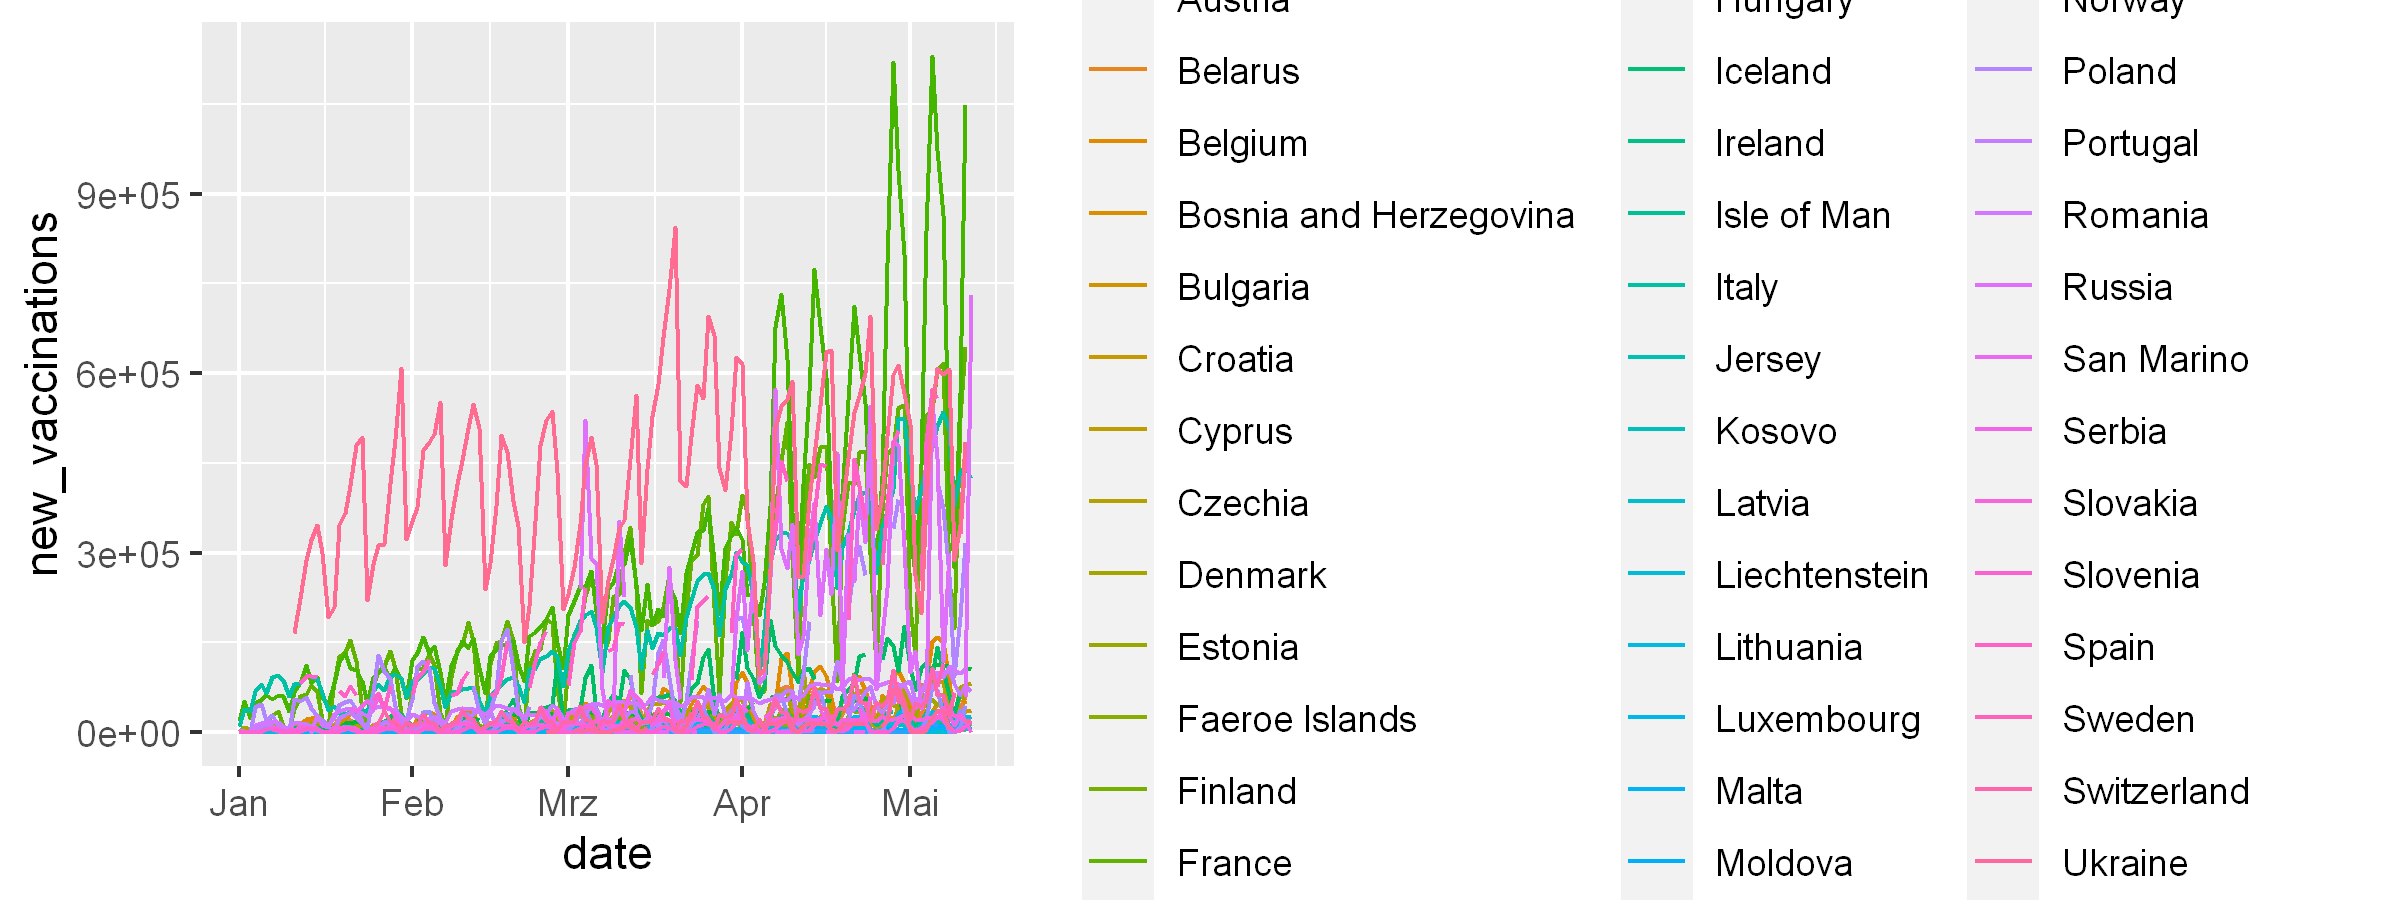

In [10]:
ggplot(df_owid[df_owid$continent =="Europe" & df_owid$date>="2021-01-01",]) +
    geom_path(aes(x=date,y=new_vaccinations, color=location)) 

In [11]:
vacc_germany <- df_owid$new_vaccinations_smoothed_per_million[df_owid$location=="Germany" & df_owid$date>="2021-01-01"]
vacc_france <-  df_owid$new_vaccinations_smoothed_per_million[df_owid$location=="France" & df_owid$date>="2021-01-01"]
correlation_france <- cor(vacc_germany, vacc_france, use="pairwise.complete.obs")
cat(paste0("Vaccination correlation with France is ", correlation_france,"\n"))


Vaccination correlation with France is 0.971665253865478


In [12]:
eur_countries <- df_owid %>% dplyr::filter(continent=="Europe") %>% extract2("location") %>% unique
eur_countries

[1] "Albania"                "Andorra"                "Austria"               
 [4] "Belarus"                "Belgium"                "Bosnia and Herzegovina"
 [7] "Bulgaria"               "Croatia"                "Cyprus"                
[10] "Czechia"                "Denmark"                "Estonia"               
[13] "Faeroe Islands"         "Finland"                "France"                
[16] "Germany"                "Gibraltar"              "Greece"                
[19] "Guernsey"               "Hungary"                "Iceland"               
[22] "Ireland"                "Isle of Man"            "Italy"                 
[25] "Jersey"                 "Kosovo"                 "Latvia"                
[28] "Liechtenstein"          "Lithuania"              "Luxembourg"            
[31] "Malta"                  "Moldova"                "Monaco"                
[34] "Montenegro"             "Netherlands"            "North Macedonia"       
[37] "Norway"                 "Poland"                 "Portugal"              
[40] "Romania"                "Russia"                 "San Marino"            
[43] "Serbia"                 "Slovakia"               "Slovenia"              
[46] "Spain"                  "Sweden"                 "Switzerland"           
[49] "Ukraine"                "United Kingdom"         "Vatican"

## Reshape-Methoden
Die Formatierung von Datensätzen lässt sich in "long" und "wide" unterteilen. Der Unterschied liegt in der Darstellung der enthaltenen Information: Beim Format "wide" existiert für jedes Attribut im Datensatz eine eigene Spalte, bei "long" existiert eine identifizierende Spalte, die Merkmale zu Individuen mappt. Zur Umwandlung gibt es (natürlich) entsprechende Funktionen.

### Ein Beispiel aus dem tidyr Paket

### Für große Datensätze ist oft eine Mischform aus long und wide effizient. Die falsche Wahl kann die Analyse sehr kompliziert machen bzw. sogar Probleme in der Speicherung verursachen. 
(siehe https://www.bbc.com/news/technology-54423988)
### Die aes Funktion aus ggplot arbeitet grundsätzlich auf dem long Format, d.h. ihr braucht zur Darstellung mehrerer Klassen eine identifizierende Spalte
Beispiel 

ggplot(df_owid) + geom_path(**aes(x=date,y=new_vaccinations, color=location)**) 

Zurück zu den Impfdaten:

In [14]:
df_vacc <- df_owid  %>% 
    dplyr::filter(location %in% c("Germany","France")) %>%
    dplyr::filter(date>="2021-01-01") %>% 
    dplyr::select(c(location,date,new_vaccinations_smoothed_per_million)) 
df_vacc %>% head

,location,date,new_vaccinations_smoothed_per_million
,<chr>,<date>,<dbl>
1,France,2021-01-01,1
2,France,2021-01-02,1
3,France,2021-01-03,1
4,France,2021-01-04,4
5,France,2021-01-05,15
6,France,2021-01-06,39


In [15]:
df_vacc %<>% tidyr::pivot_wider(names_from= location, values_from=new_vaccinations_smoothed_per_million)
df_vacc %>% head

date,France,Germany
<date>,<dbl>,<dbl>
2021-01-01,1,479
2021-01-02,1,503
2021-01-03,1,472
2021-01-04,4,523
2021-01-05,15,528
2021-01-06,39,528


In [16]:
df_vacc %>% 
    dplyr::select(-date)  %>% 
    cor(use="pairwise.complete.obs")

,France,Germany
France,1.0000000,0.9716653
Germany,0.9716653,1.0000000


# Aufgabe
* Überlegt euch, wie der OWID Datensatz komplett "long" aussehen würde.
* Berechnet zunächst für jedes europäische Land einzeln die Korrelation zwischen Infektionszahlen und Todeszahlen.
* Berechnet nun die Korrelationen der Impfgeschwindigkeit aller europäischen Länder.
* Erstellt einen sogenannten Korrelationsplot, das heißt einen Plot der Korrelationsmatrix. Sucht dafür nach einer passenden ggplot Funktion.











In [17]:
df_owid %>% names

[1] "iso_code"                             
 [2] "continent"                            
 [3] "location"                             
 [4] "date"                                 
 [5] "total_cases"                          
 [6] "new_cases"                            
 [7] "new_cases_smoothed"                   
 [8] "total_deaths"                         
 [9] "new_deaths"                           
[10] "new_deaths_smoothed"                  
[11] "total_cases_per_million"              
[12] "new_cases_per_million"                
[13] "new_cases_smoothed_per_million"       
[14] "total_deaths_per_million"             
[15] "new_deaths_per_million"               
[16] "new_deaths_smoothed_per_million"      
[17] "reproduction_rate"                    
[18] "icu_patients"                         
[19] "icu_patients_per_million"             
[20] "hosp_patients"                        
[21] "hosp_patients_per_million"            
[22] "weekly_icu_admissions"                
[23] "weekly_icu_admissions_per_million"    
[24] "weekly_hosp_admissions"               
[25] "weekly_hosp_admissions_per_million"   
[26] "new_tests"                            
[27] "total_tests"                          
[28] "total_tests_per_thousand"             
[29] "new_tests_per_thousand"               
[30] "new_tests_smoothed"                   
[31] "new_tests_smoothed_per_thousand"      
[32] "positive_rate"                        
[33] "tests_per_case"                       
[34] "tests_units"                          
[35] "total_vaccinations"                   
[36] "people_vaccinated"                    
[37] "people_fully_vaccinated"              
[38] "new_vaccinations"                     
[39] "new_vaccinations_smoothed"            
[40] "total_vaccinations_per_hundred"       
[41] "people_vaccinated_per_hundred"        
[42] "people_fully_vaccinated_per_hundred"  
[43] "new_vaccinations_smoothed_per_million"
[44] "stringency_index"                     
[45] "population"                           
[46] "population_density"                   
[47] "median_age"                           
[48] "aged_65_older"                        
[49] "aged_70_older"                        
[50] "gdp_per_capita"                       
[51] "extreme_poverty"                      
[52] "cardiovasc_death_rate"                
[53] "diabetes_prevalence"                  
[54] "female_smokers"                       
[55] "male_smokers"                         
[56] "handwashing_facilities"               
[57] "hospital_beds_per_thousand"           
[58] "life_expectancy"                      
[59] "human_development_index"

In [19]:
df_owid %>% 
    dplyr::select(-tests_units) %>% 
    tidyr::pivot_longer(cols=!c('iso_code','continent','location','date')) %>% 
    head(20)

iso_code,continent,location,date,name,value
<chr>,<chr>,<chr>,<date>,<chr>,<dbl>
AFG,Asia,Afghanistan,2020-02-24,total_cases,1.000
AFG,Asia,Afghanistan,2020-02-24,new_cases,1.000
AFG,Asia,Afghanistan,2020-02-24,new_cases_smoothed,NA
AFG,Asia,Afghanistan,2020-02-24,total_deaths,NA
AFG,Asia,Afghanistan,2020-02-24,new_deaths,NA
AFG,Asia,Afghanistan,2020-02-24,new_deaths_smoothed,NA
AFG,Asia,Afghanistan,2020-02-24,total_cases_per_million,0.026
AFG,Asia,Afghanistan,2020-02-24,new_cases_per_million,0.026
AFG,Asia,Afghanistan,2020-02-24,new_cases_smoothed_per_million,NA


In [20]:
df_owid  %>% 
    dplyr::filter(continent=="Europe") %>%
    dplyr::filter(date>="2021-01-01") %>% 
    dplyr::select(c(location,date,new_vaccinations_smoothed_per_million))  %>% head

,location,date,new_vaccinations_smoothed_per_million
,<chr>,<date>,<dbl>
1,Albania,2021-01-01,NA
2,Albania,2021-01-02,NA
3,Albania,2021-01-03,NA
4,Albania,2021-01-04,NA
5,Albania,2021-01-05,NA
6,Albania,2021-01-06,NA


In [21]:
df_vacc <-  df_owid  %>% 
    dplyr::filter(continent=="Europe") %>%
    dplyr::filter(date>="2021-01-01") %>% 
    dplyr::select(c(location,date,new_vaccinations_smoothed_per_million)) %>% 
    tidyr::pivot_wider(names_from= location, values_from=new_vaccinations_smoothed_per_million)
df_vacc

date,Albania,Andorra,Austria,Belarus,Belgium,Bosnia and Herzegovina,Bulgaria,Croatia,Cyprus,...,San Marino,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland,Ukraine,United Kingdom,Vatican
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01,NA,NA,95,43,11,NA,145,269,NA,...,NA,NA,NA,498,NA,190,NA,NA,NA,NA
2021-01-02,NA,NA,79,43,9,NA,115,269,NA,...,NA,NA,NA,448,NA,190,NA,NA,NA,NA
2021-01-03,NA,NA,68,43,7,NA,97,269,NA,...,NA,NA,NA,422,NA,190,NA,NA,NA,NA
2021-01-04,NA,NA,49,43,6,NA,85,252,NA,...,NA,NA,NA,390,NA,234,NA,NA,2684,NA
2021-01-05,NA,NA,52,43,27,NA,77,241,NA,...,NA,NA,78,474,1209,277,NA,NA,2684,NA
2021-01-06,NA,NA,44,43,69,NA,68,325,NA,...,NA,NA,606,811,968,321,NA,NA,2684,NA
2021-01-07,NA,NA,94,43,170,NA,132,405,610,...,NA,NA,834,1058,888,365,NA,NA,2684,NA
2021-01-08,NA,NA,300,43,284,NA,177,519,610,...,NA,NA,948,1269,1043,408,NA,NA,2684,NA
2021-01-09,NA,NA,370,43,323,NA,176,655,610,...,NA,169,817,1259,1017,452,NA,NA,2684,NA


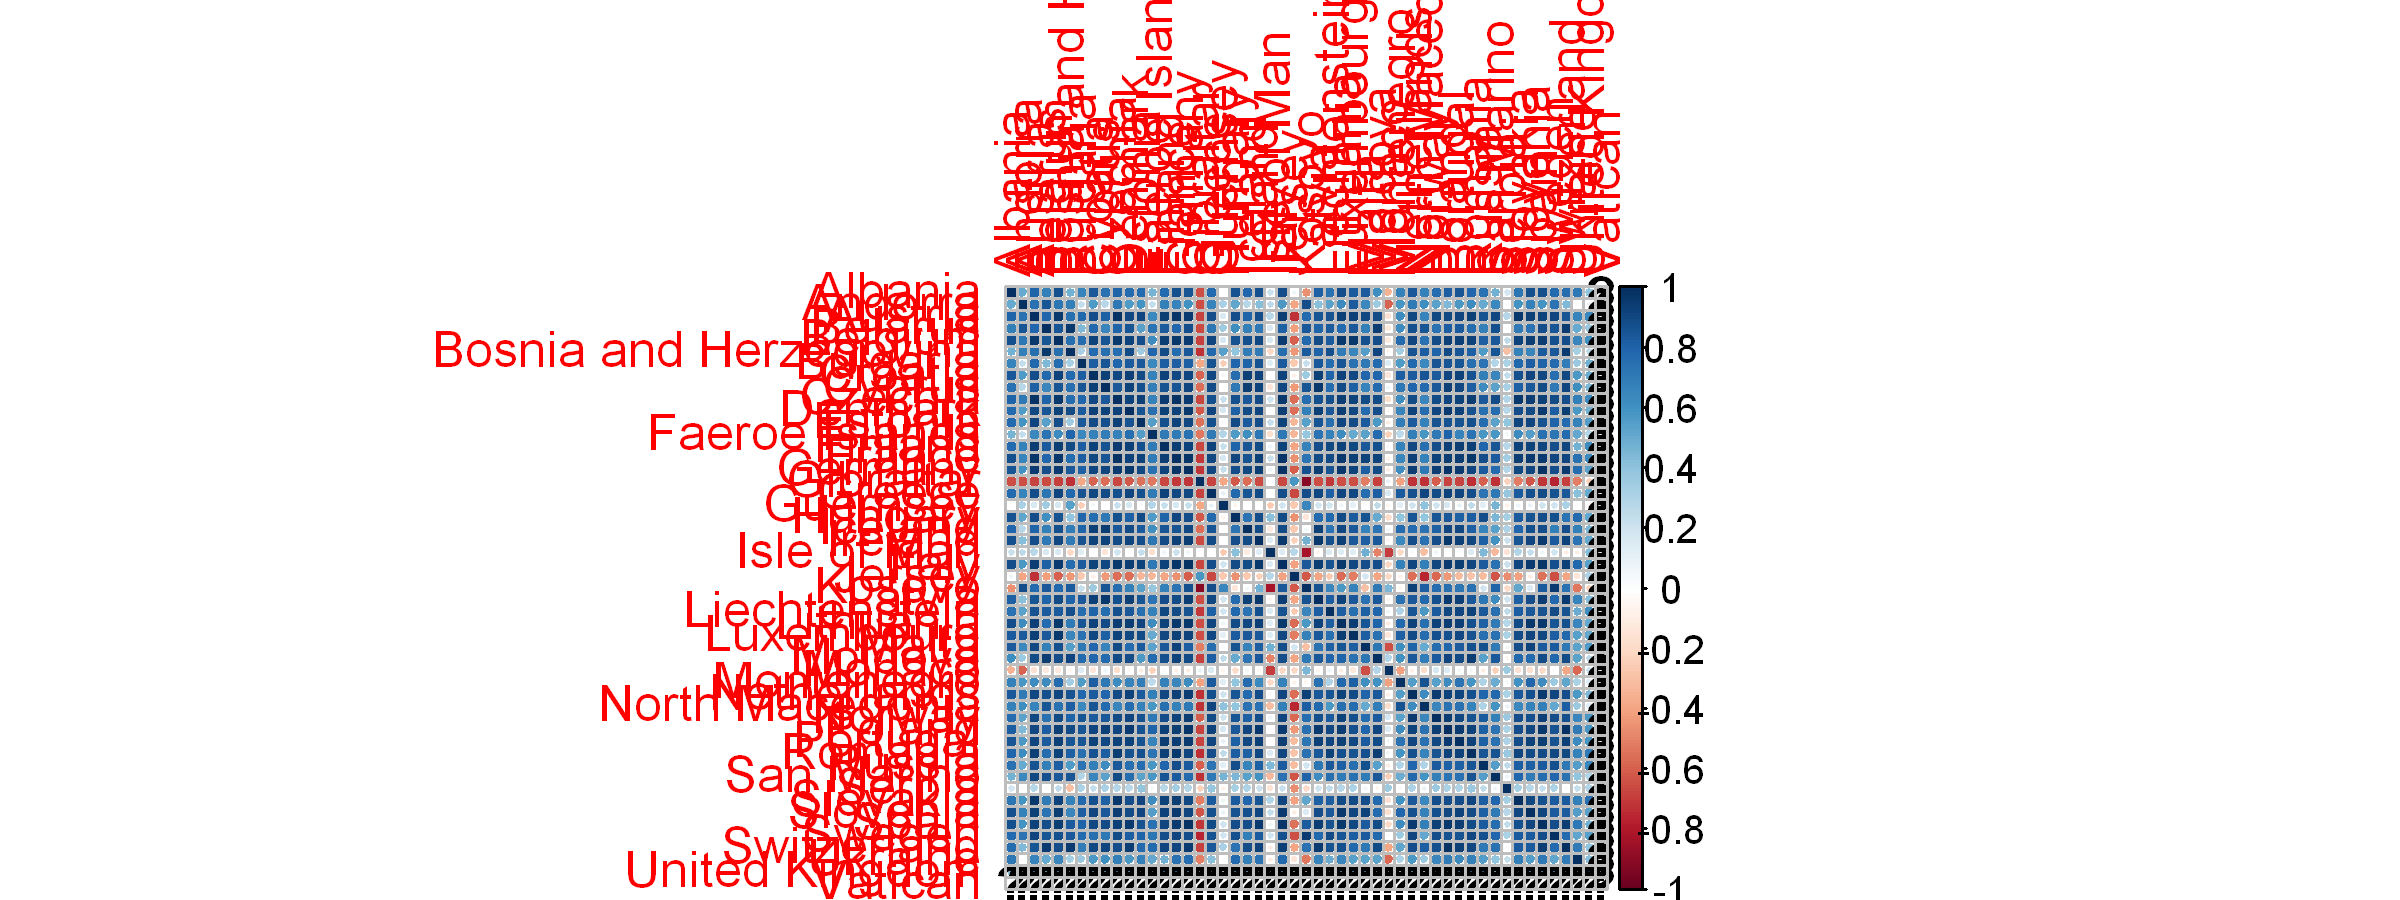

In [22]:
corr_matrix <- df_vacc %>% dplyr::select(-date) %>% cor(use="pairwise.complete.obs")
corrplot::corrplot(corr_matrix)

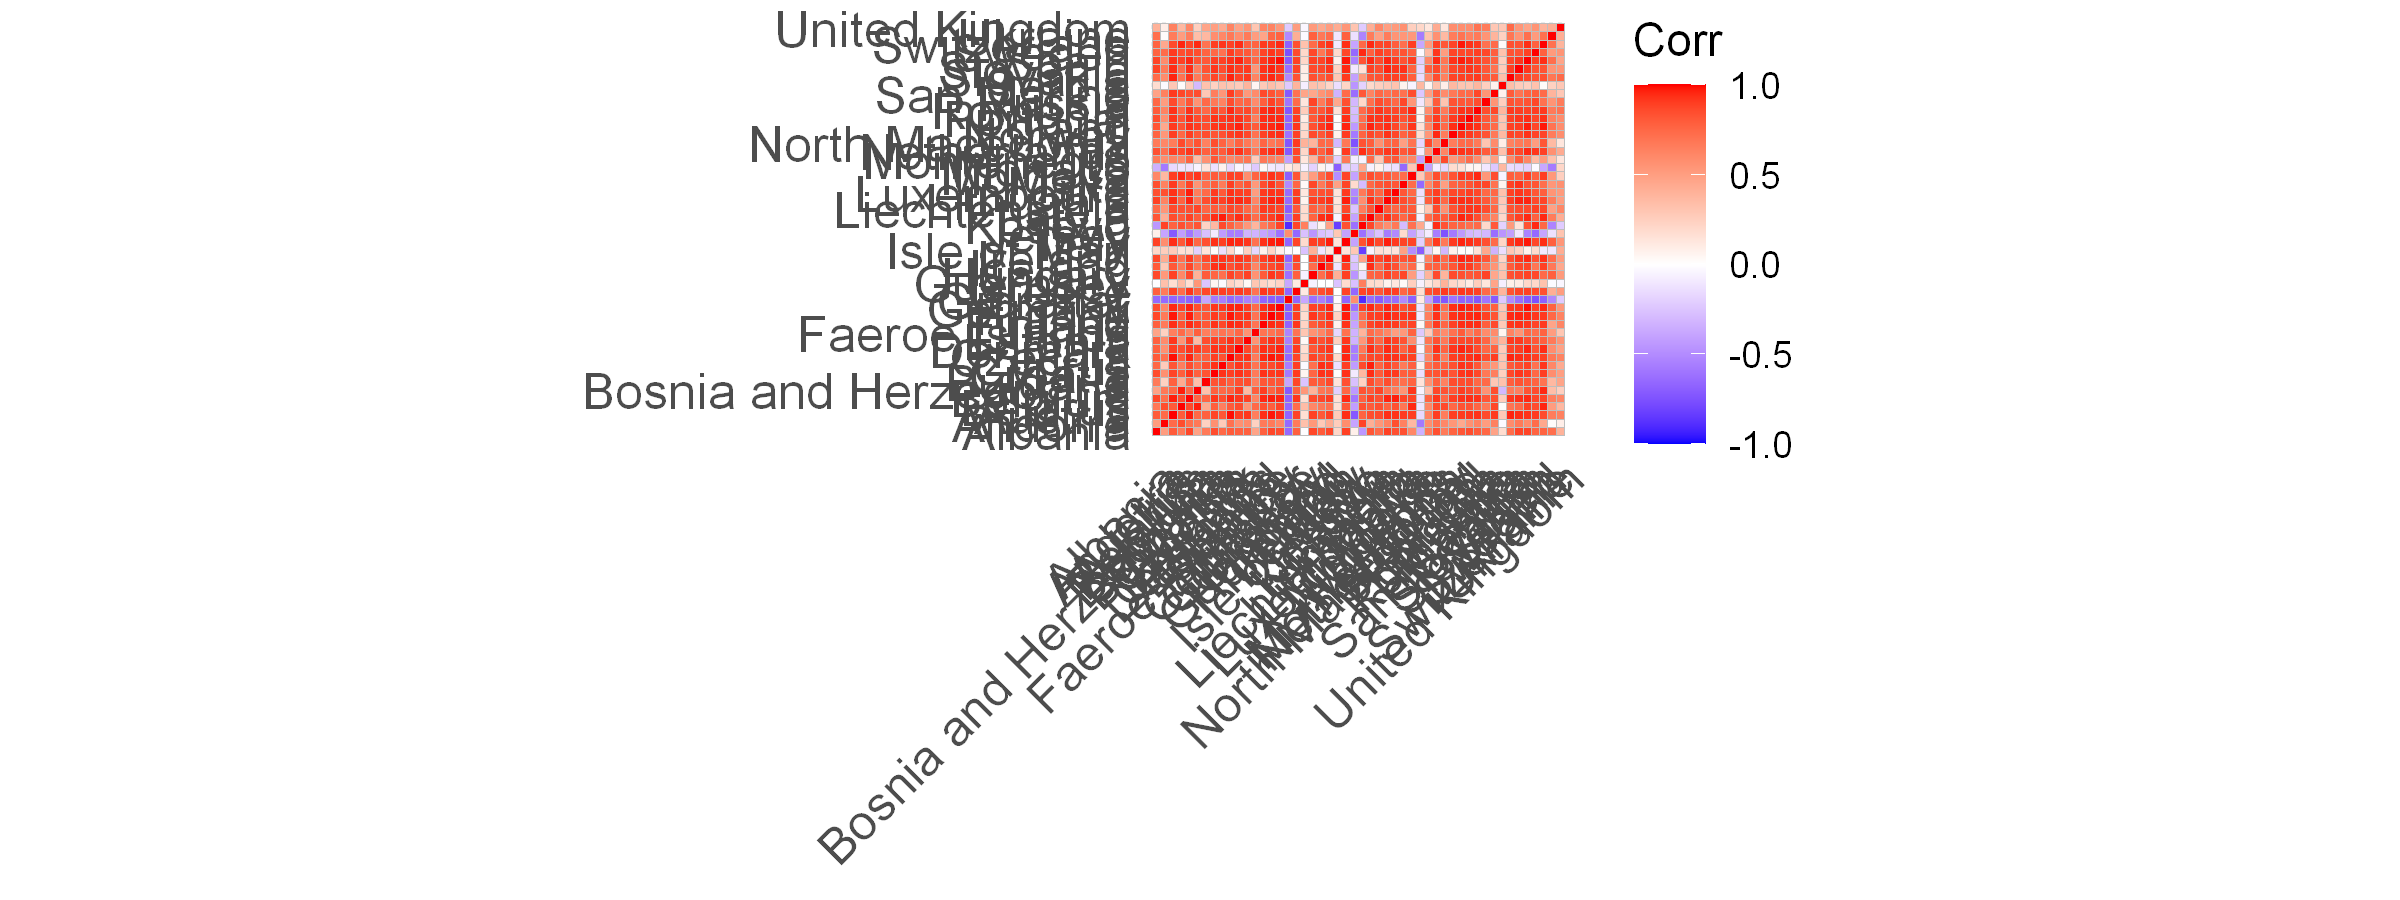

In [23]:
ggcorrplot::ggcorrplot(corr_matrix) 